In [1]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input

from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
from keras.layers import Conv2D, MaxPool2D, Flatten

In [4]:
def face(img):
    img = img[70:195,78:172]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img

In [5]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val+1, folder), end="\r")

In [6]:
dataset_folder = "dataset/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    if len(files) < 50 :
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = face(img) # detect face using mtcnn and crop to 100x100
            if img is not None :
                images.append(img)
                names.append(folder)

                print_progress(i, len(files), folder)


[####################] (77 samples)	 label : Ariel_Sharon 		
[####################] (150 samples)	 label : Colin_Powell 		
[####################] (121 samples)	 label : Donald_Rumsfeld 		
[####################] (150 samples)	 label : George_W_Bush 		
[####################] (109 samples)	 label : Gerhard_Schroeder 		
[####################] (71 samples)	 label : Hugo_Chavez 		
[####################] (52 samples)	 label : Jacques_Chirac 		
[####################] (55 samples)	 label : Jean_Chretien 		
[####################] (53 samples)	 label : John_Ashcroft 		
[####################] (60 samples)	 label : Junichiro_Koizumi 		
[####################] (52 samples)	 label : Pangestu 		
[####################] (52 samples)	 label : Serena_Williams 		
[####################] (144 samples)	 label : Tony_Blair 		


In [7]:
print("number of samples :", len(names))

number of samples : 1201


### Image Augmentation

In [8]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

Cek Hasil Augmentasi gambar

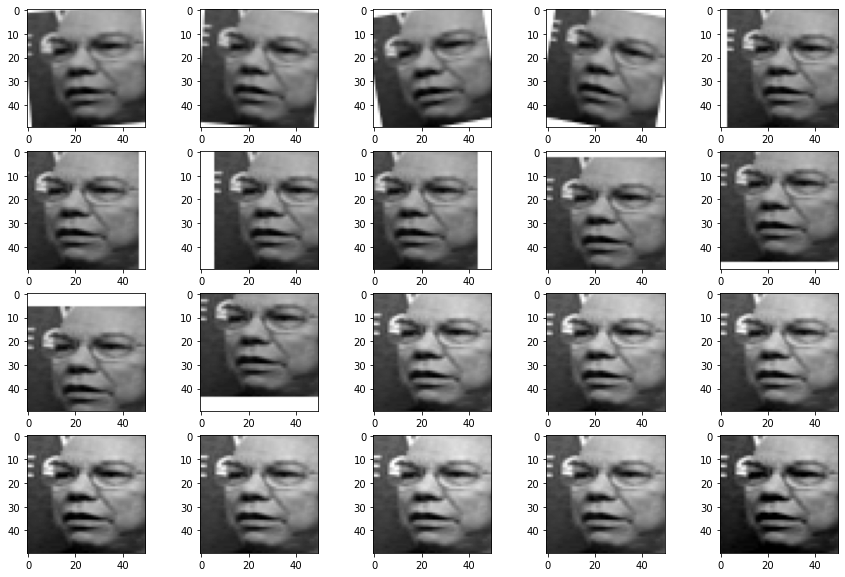

In [9]:
img_test = images[200]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

Simpan Hasil Image Augmentation

In [10]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)

Cek Total Image Hasil Augmentation 

In [11]:
len(augmented_images), len(augmented_names)

(24020, 24020)

In [12]:
images.extend(augmented_images)
names.extend(augmented_names)

Total Image Augmentation di tambah total dataset original

In [13]:
len(images), len(names)

(25221, 25221)

In [14]:
unique, counts = np.unique(names, return_counts = True)

for item in zip(unique, counts):
    print(item)

('Ariel_Sharon', 1617)
('Colin_Powell', 3150)
('Donald_Rumsfeld', 2541)
('George_W_Bush', 3150)
('Gerhard_Schroeder', 2289)
('Hugo_Chavez', 1491)
('Jacques_Chirac', 1092)
('Jean_Chretien', 1155)
('John_Ashcroft', 1113)
('Junichiro_Koizumi', 1260)
('Pangestu', 1092)
('Serena_Williams', 1092)
('Tony_Blair', 3024)
('yoga', 1155)


### Balancing Data

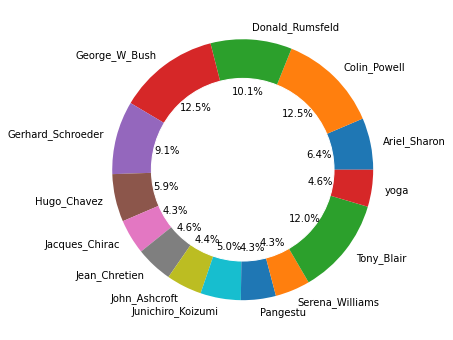

In [15]:
# preview data distribution

def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    
unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [16]:
# reduce sample size per-class using numpy random choice
n = 1000

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [17]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

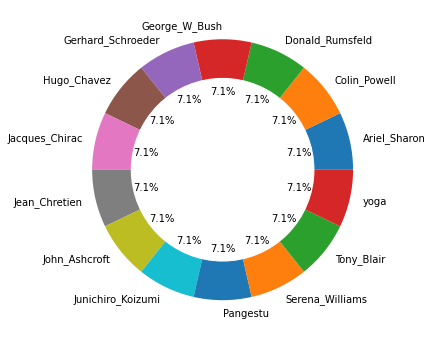

In [18]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [19]:
len(names)

14000

### Encoder & Categorical

In [20]:
#Trasnform terlebih dahulu menggunakan label encoder 
le = LabelEncoder()
le.fit(names)
labels = le.classes_
name_vec = le.transform(names)

#Hasil dari transform simpan ke dalam fung categorical punya library keras
categorical_name_vec = to_categorical(name_vec)

In [21]:
print("number of class :", len(labels))
print(labels)

number of class : 14
['Ariel_Sharon' 'Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush'
 'Gerhard_Schroeder' 'Hugo_Chavez' 'Jacques_Chirac' 'Jean_Chretien'
 'John_Ashcroft' 'Junichiro_Koizumi' 'Pangestu' 'Serena_Williams'
 'Tony_Blair' 'yoga']


In [22]:
print(name_vec)

[ 0  0  0 ... 13 13 13]


In [23]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Split Dataset

In [24]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.15,                       # 15% untuk testing, 70% untuk training
                                                    random_state=42)

In [25]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

#11900 untuk train
#sisanya untuk test

(11900, 50, 50) (11900, 14) (2100, 50, 50) (2100, 14)


### Reshape Data

In [26]:
#dimensi x_train masih 1D (11050, 50,50 ) > jumlah sampel kali 50X50
#sementara tiap sampelnya cnn ekspek 3D, karena ini layernya grayscale paling tidak (11050, 50,50, 1)
#oleh karena itu perlu di reshape datanya biar hasilnya (11050, 50,50, 1)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1) # dimensi akhirnya tambahin '1'
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [27]:
x_train.shape, x_test.shape

((11900, 50, 50, 1), (2100, 50, 50, 1))

### Create CNN Model

In [28]:
def cnn_model(input_shape):  
    model = Sequential() # > membuat dengan sequentialnya keras
    
    model.add(Conv2D(64,                      #64 kernel di layer pertama
                    (3,3),                    #dengan ukuran kernel/size 3x3
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape)) #sama 
    
    model.add(MaxPool2D(pool_size=(2, 2)))    #kemudian di tambahin maxpooling layer harapanya, karena dimensi di convolution 2D
                                              #diatas masih tinggi, setelah menggunakan max pooling dengan pool size 2,2
                                              #secara otomatis dimensinya akan menjadi setengahnya 
    
    model.add(Conv2D(128,                     #kemudian proses lagi kedalam convolutional 2D dengan  jumlah kernel 128 
                    (3,3),                    #dan ukuran size kernelnya 3x3
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))       #harapanya bisa untuk menangkap local pictures wajah dengan baik 
    
    model.add(MaxPool2D(pool_size=(2, 2)))    #tujuanya untuk mereducsi lagi dimensi datanya(apabila tadi di kisaran 25,
                                              #maka ini bisa kesetangahnya kisaran 10x10pixel )
    
    model.add(Flatten())                      #kemudian flatten dari hasil pooling sehingga dimensinya akan menjadi 1D,
                                              #yang tadinya 2D, karena sudah menjadi 1D, maka bisa dimasukan kedalam lapisan
                                              #dense layer
    
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(labels)))             #menyesuaikan jumlah kelas yang digunakan
    model.add(Activation("softmax"))          #activation layer 'softmax' karena kasus kali ini merupakan image classification 
                                              #sebenarnya ada 2 opsi untuk image classification bisa menggunakan sigmoid / softmax
                                              #tapi kalau multi class/ classnya banyak maka di sarankan untuk menggunakan softmax
    
    model.summary() 
    
    optimizer=keras.optimizers.RMSprop(lr=0.001)
    model.compile(optimizer='optimizer', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

### 1.5 Training CNN Model

In [30]:
input_shape = x_train[0].shape

EPOCHS = 10
BATCH_SIZE = 32

model = cnn_model(input_shape)

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 19, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10368)            

In [29]:
####### convolutional di awal ada 2 , kemudian ada dimensi output/dimensi fiture map (48, 48, 64), kenapa enggak 50,50 ?
####### karena padding yang dimasukan 'valid', jika ingin mengubah hasilnya sama 50,50 makan paddingnya ganti menjadi 'same'
####### 64 adalah jumlah kernel yang digunakan di dalam convulotional layer pertama

####### max polling, karena pool size nya tadi yang di inputkan 2x2, maka hasilnya setengahnya 

####### kemudian ada convolutional ke-3 dan ke-4 
####### kemudian dilanjut lagi untuk max pooling kedua, tiap sampel mempunyai ukuran 9x9 dengan 128 lembar 

####### kemudian flatten untuk array 1D maka (9,9, 128) hasilnya menjadi 10368 value
####### lalu masukan kedalam dense laye 1, dense layer2, dan dense layer 3
####### kenapa di dense layer terakhir(dense ke 3) hasilnya 13 ? cause jumlah sampel yang digunakan ada 13 class

####### loss     : nilai error pada saat training 
####### accuracy : nilai accuracy pada saat training

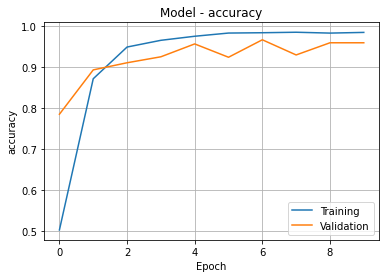

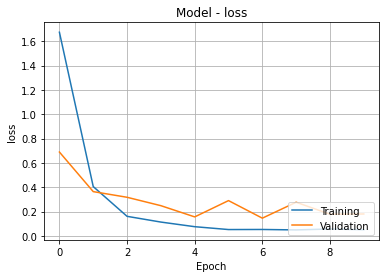

In [34]:
def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()
        
evaluate_model_(history)

In [35]:
training_accuracy = history.history['accuracy'][-1]
training_loss = history.history['loss'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
validation_loss = history.history['val_loss'][-1]

print("Training Accuracy CNN   :", training_accuracy)
print("Training Loss CNN       :", training_loss)
print("Validation Accuracy CNN :", validation_accuracy)
print("Validation Loss CNN     :", validation_loss)

Training Accuracy CNN   : 0.98437965
Training Loss CNN       : 0.05105154058861823
Validation Accuracy CNN : 0.9591036438941956
Validation Loss CNN     : 0.18042837486887942


In [36]:
model.save("modelfacerecognition.h5")

In [37]:
# predict test data
y_pred=model.predict(x_test)

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

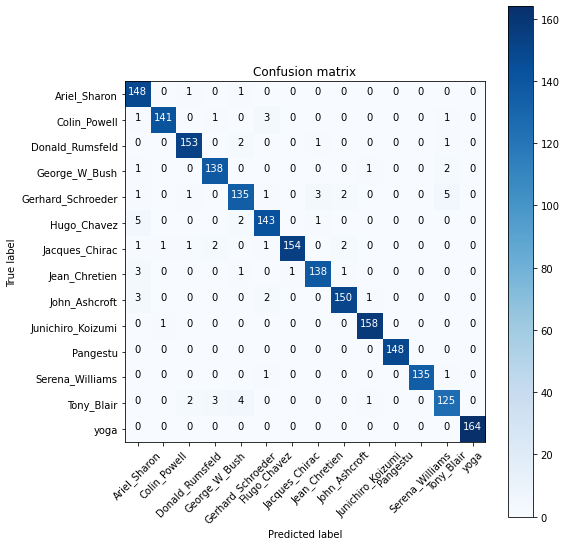

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')


In [40]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.91      0.99      0.95       150
     Colin_Powell       0.99      0.96      0.97       147
  Donald_Rumsfeld       0.97      0.97      0.97       157
    George_W_Bush       0.96      0.97      0.97       142
Gerhard_Schroeder       0.93      0.91      0.92       148
      Hugo_Chavez       0.95      0.95      0.95       151
   Jacques_Chirac       0.99      0.95      0.97       162
    Jean_Chretien       0.97      0.96      0.96       144
    John_Ashcroft       0.97      0.96      0.96       156
Junichiro_Koizumi       0.98      0.99      0.99       159
         Pangestu       1.00      1.00      1.00       148
  Serena_Williams       1.00      0.99      0.99       137
       Tony_Blair       0.93      0.93      0.93       135
             yoga       1.00      1.00      1.00       164

         accuracy                           0.97      2100
        macro avg       0.97      0.97      0.97      

### 1. Convert Keras (.h5) to Tensorflow (.pb)

In [42]:
import keras
import tensorflow as tf

print(keras.__version__)
print(tf.__version__)

2.3.0
2.2.3


- load keras model (.h5)

In [44]:
model = tf.keras.models.load_model('modelfacerecognition.h5')

- save model as a folder `'new_model/'`

In [45]:
model.save("new_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: new_model\assets


In [46]:
! dir new_model

 Volume in drive C is Windows-SSD
 Volume Serial Number is E2E4-92E0

 Directory of C:\Users\LENOVO\Downloads\UAS\NewPartCNN\UAS\new_model

18/06/2022  10:21    <DIR>          .
18/06/2022  10:21    <DIR>          ..
18/06/2022  10:21    <DIR>          assets
18/06/2022  10:21           195.689 saved_model.pb
18/06/2022  10:21    <DIR>          variables
               1 File(s)        195.689 bytes
               4 Dir(s)   8.704.049.152 bytes free


### 2. View Input & Output model graph (.pb)

In [47]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
#convert_variables_to_constants_v2 -> digunakan untuk meng inspect atau melihat isi file .pb di dalam folder 'new_model'

In [48]:
importer = tf.saved_model.load("new_model/")
#load model yang 'new_model'

In [49]:
infer = importer.signatures['serving_default']

In [50]:
f = convert_variables_to_constants_v2(infer)
graph_def = f.graph.as_graph_def()

for n in graph_def.node:
    print( n.name, n.op)

#print atau baca seluruh informasi layer di dalam model yang telah dibuat sebelumnya     

conv2d_1_input Placeholder
unknown_10 Const
unknown_11 Const
unknown_1 Const
unknown_4 Const
unknown Const
unknown_12 Const
unknown_6 Const
unknown_0 Const
unknown_2 Const
unknown_7 Const
unknown_3 Const
unknown_8 Const
unknown_5 Const
unknown_9 Const
Func/StatefulPartitionedCall/input_control_node/_0 NoOp
Func/StatefulPartitionedCall/input/_1 Identity
Func/StatefulPartitionedCall/input/_2 Identity
StatefulPartitionedCall/sequential_1/conv2d_1/Conv2D/ReadVariableOp Identity
StatefulPartitionedCall/sequential_1/conv2d_1/Conv2D Conv2D
Func/StatefulPartitionedCall/input/_3 Identity
StatefulPartitionedCall/sequential_1/conv2d_1/BiasAdd/ReadVariableOp Identity
StatefulPartitionedCall/sequential_1/conv2d_1/BiasAdd BiasAdd
StatefulPartitionedCall/sequential_1/conv2d_1/Relu Relu
Func/StatefulPartitionedCall/input/_4 Identity
StatefulPartitionedCall/sequential_1/conv2d_2/Conv2D/ReadVariableOp Identity
StatefulPartitionedCall/sequential_1/conv2d_2/Conv2D Conv2D
Func/StatefulPartitionedCall/input

### 3. Convert Model (.pb) to frozen model graph (.pb) & Optimize for Inference

In [51]:
from tensorflow.python.tools import optimize_for_inference_lib
#optimize_for_inference_lib -> fungsi ini digunakan untuk meng optimalkan model yang kita punya 

In [52]:
f = convert_variables_to_constants_v2(infer)
graph_def = f.graph.as_graph_def()

graph_def = optimize_for_inference_lib.optimize_for_inference(graph_def,
                                                              ['conv2d_1_input'],
                                                              ['Identity'],
                                                              tf.float32.as_datatype_enum)

with tf.io.gfile.GFile('frozen_graph.pb', 'wb') as f:
    f.write(graph_def.SerializeToString())

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
cv2.__version__

'4.5.2'

In [5]:
labels = ['Ariel_Sharon',
          'Colin_Powell',
          'Donald_Rumsfeld',
          'George_W_Bush',
          'Gerhard_Schroeder',
          'Hugo_Chavez',
          'Jacques_Chirac',
          'Jean_Chretien',
          'John_Ashcroft',
          'Junichiro_Koizumi',
          'Serena_Williams',
          'Tony_Blair',
          'Yoga',
          'Pangestu']

In [6]:
facerecognition_model = "frozen_graph.pb"
net = cv2.dnn.readNet(facerecognition_model)

In [7]:
# set backend & target OpenCV DNN

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [8]:
layerOutput = net.getUnconnectedOutLayersNames()

In [9]:
layerOutput

['StatefulPartitionedCall/sequential_1/activation_1/Softmax']

### 4. Testing 

In [10]:
def detect_face(img):
    img = img[70:195,78:172]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img

In [11]:
os.listdir("test_data/")

['Colin_Powell_0008.jpg',
 'Donald_Rumsfeld_0009.jpg',
 'George_W_Bush_0016.jpg',
 'Gerhard_Schroeder_0012.jpg',
 'Pangestu_0009.jpg',
 'Tony_Blair_0012.jpg',
 'yoga25.jpg']

In [64]:
img = cv2.imread("test_data/yoga25.jpg")

img = detect_face(img)

blob = cv2.dnn.blobFromImage(img, 1.0, (50, 50), (0, 0, 0), swapRB=True, crop=False)

In [65]:
img.shape, blob.shape

((50, 50), (1, 1, 50, 50))

In [66]:
net.setInput(blob)
output = net.forward(layerOutput)

In [67]:
output #bentuk nilainya probability distribution 

[array([[1.63e-12, 4.83e-08, 8.53e-08, 1.37e-09, 2.51e-10, 9.54e-12,
         1.40e-08, 6.37e-11, 4.35e-08, 3.33e-11, 6.85e-11, 1.23e-10,
         2.46e-08, 1.00e+00]], dtype=float32)]

In [68]:
idx = output[0].argmax(axis=1)[0]          #untuk melakukan prediksi gunakan nilai probability yang paling besar oleh karena itu bisa menggunakan fungsion numpy argmax

confidence = output[0].max(axis=1)[0]*100

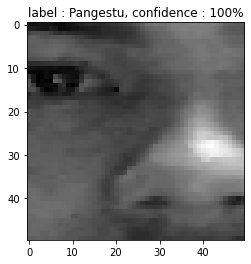

In [69]:
plt.imshow(img, cmap="gray")
plt.title("label : %s, confidence : %2.f%%" % (labels[idx], confidence))
plt.show()

### 5. Testing With CaseCade

In [71]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [72]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [80]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
facerecognition_model = "frozen_graph.pb"
net = cv2.dnn.readNet(facerecognition_model)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
layerOutput = net.getUnconnectedOutLayersNames()

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            
            blob = cv2.dnn.blobFromImage(face_img, 1.0, (50, 50), (0, 0, 0), swapRB=True, crop=False)
            net.setInput(blob)
            output = net.forward(layerOutput)
            idx = output[0].argmax(axis=1)[0]
            confidence = output[0].max(axis=1)[0]*100
            
            if confidence > 70:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
                #request api
            else :
                label_text = "N/A"
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Face Recognition', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

### 6. Testing With MTCNN

In [75]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

In [76]:
detector_mtcnn = MTCNN()

In [77]:
from utils import Ped

In [78]:
# --------- load MTCNN model -------------
detector_mtcnn = MTCNN()

# --------- load tensorflow optimized model ---------
facerecognition_model = "frozen_graph.pb"
net = cv2.dnn.readNet(facerecognition_model)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
layerOutput = net.getUnconnectedOutLayersNames()

cap = cv2.VideoCapture(0)

ped = Ped()

while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        faces = detector_mtcnn.detect_faces(frame)
        for face in faces:
            x, y, w, h = face['box']
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            
            blob = cv2.dnn.blobFromImage(face_img, 1.0, (50, 50), (0, 0, 0), swapRB=True, crop=False)
            net.setInput(blob)
            output = net.forward(layerOutput)
            idx = output[0].argmax(axis=1)[0]
            confidence = output[0].max(axis=1)[0]*100
            
            if confidence > 60:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "N/A"
            frame = ped.draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Face Recognition', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()